In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

import cartopy.crs as ccrs
import cartopy.feature as cf
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean

In [2]:
import graphufs

plt.style.use("graphufs.plotstyle")

/contrib2/Tim.Smith/graph-ufs/graphufs/training.py:59: UserWarning: Import failed for either mpi4py or mpi4jax.
  warnings.warn("Import failed for either mpi4py or mpi4jax.")


In [3]:
def swap_dims(xds):

    if "prediction_timedelta" in xds.coords and "lead_time" not in xds.coords:
        xds = xds.rename({"prediction_timedelta": "lead_time"})
    
    xds["fhr"] = (xds.lead_time.astype(int) / 3600 / 1e9).astype(int)
    xds = xds.swap_dims({"lead_time": "fhr"})
    return xds

In [4]:
def open_dataset(*args, **kwargs):
    xds = xr.open_dataset(*args, **kwargs)
    xds = swap_dims(xds)
    return xds

In [5]:
def open_zarr(*args, **kwargs):
    xds = xr.open_zarr(*args, **kwargs)
    xds = swap_dims(xds)
    
    xds["valid_time"] = xds.time + xds.lead_time
    xds = xds.set_coords("valid_time")
    return xds

In [6]:
gds = open_zarr("/p1-evaluation/v1/validation/graphufs.240h.zarr/")

In [7]:
era = xr.open_zarr(
    "gs://weatherbench2/datasets/era5/1959-2023_01_10-full_37-1h-0p25deg-chunk-1.zarr",
    storage_options={"token": "anon"},
)
era = era.sel(
    time=slice(
        gds.time.isel(time=0).values,
        gds.valid_time.isel(time=-1, fhr=-1).values
    ),
    level=[100,500,850],
)

In [8]:
gds["10m_wind_speed"] = np.sqrt(gds["ugrd10m"]**2 + gds["vgrd10m"]**2)
era["10m_wind_speed"] = np.sqrt(era["10m_u_component_of_wind"]**2 + era["10m_v_component_of_wind"]**2)

In [9]:
from graphufs.spatialmap import SpatialMap

In [14]:
mapper = SpatialMap()

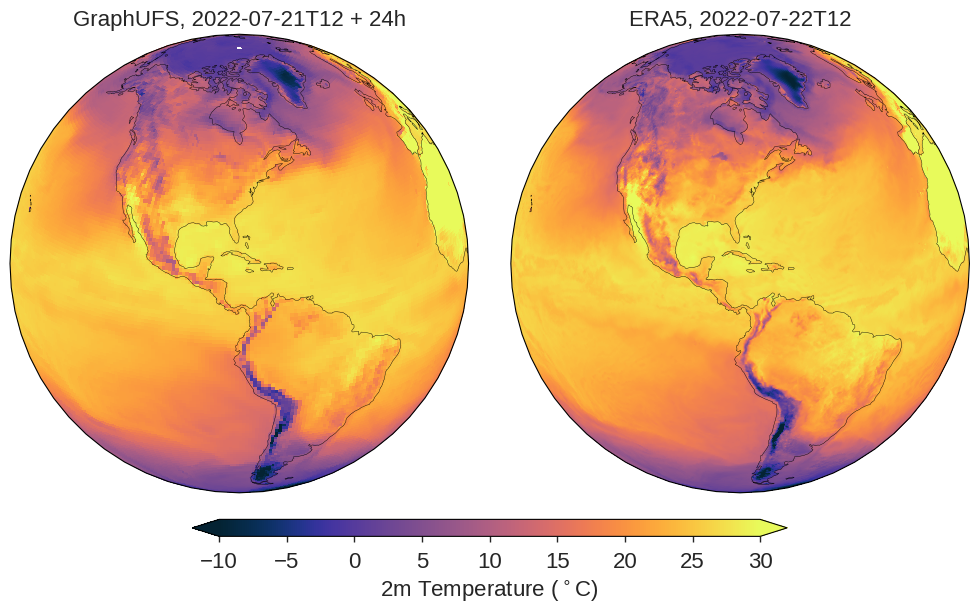

In [21]:
gda = gds["tmp2m"].isel(time=179).sel(fhr=24)
eda = era["2m_temperature"].sel(time=[gda.valid_time.values])
fig, axs = mapper.plot(gda, eda)
fig.savefig(f"figures/graphufs_and_era5_tmp2m_24h.jpeg", bbox_inches="tight", dpi=300)

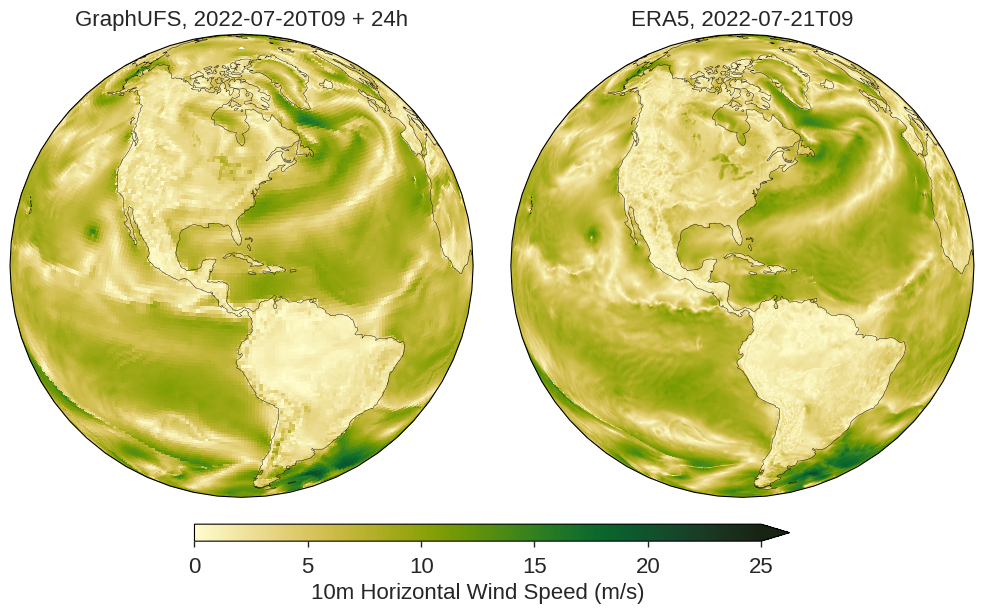

In [22]:
gda = gds["10m_wind_speed"].isel(time=178).sel(fhr=24)
eda = era["10m_wind_speed"].sel(time=[gda.valid_time.values])
fig, axs = mapper.plot(gda, eda)
fig.savefig(f"figures/graphufs_and_era5_windspeed_24h.jpeg", bbox_inches="tight", dpi=300)